In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os, math
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pandas_summary import DataFrameSummary
from tqdm import tqdm, tqdm_notebook
from pathlib import Path
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 400)
sns.set()

os.chdir('../..')
from src import utils

In [2]:
DATA        = Path('data')
RAW         = DATA/'raw'
INTERIM     = DATA/'interim'
PROCESSED   = DATA/'processed'
SUBMISSIONS = DATA/'submissions'

In [50]:
customer   = pd.read_csv(RAW/'Customer.csv', low_memory=False)
isin       = pd.read_csv(RAW/'Isin.csv', low_memory=False)

In [5]:
challenge  = pd.read_csv(RAW/'Challenge_20180423.csv', low_memory=False)
trade      = pd.read_csv(RAW/'Trade.csv', low_memory=False)
trade.TradeDateKey.min(), trade.TradeDateKey.max()

(20160101, 20180422)

In [19]:
from src.utils import get_weeks
week_labels = get_weeks(day_from=20160104, num_weeks=121)

In [23]:
%%time
from src.utils import make_val_set
weeks = [make_val_set(trade[trade.TradeDateKey.apply(lambda x: w1<=x<w2)], 
                    challenge) for w1, w2 in zip(week_labels[:-1], week_labels[1:])]

CPU times: user 1h 14min 49s, sys: 17.1 s, total: 1h 15min 6s
Wall time: 1h 15min 7s


In [24]:
for w in weeks:
    print(w.CustomerInterest.value_counts())

0.0    490736
1.0     11020
Name: CustomerInterest, dtype: int64
0.0    492114
1.0     12692
Name: CustomerInterest, dtype: int64
0.0    492243
1.0     12943
Name: CustomerInterest, dtype: int64
0.0    512195
1.0     13573
Name: CustomerInterest, dtype: int64
0.0    489960
1.0      8000
Name: CustomerInterest, dtype: int64
0.0    491214
1.0     11350
Name: CustomerInterest, dtype: int64
0.0    492358
1.0     12858
Name: CustomerInterest, dtype: int64
0.0    492795
1.0     13571
Name: CustomerInterest, dtype: int64
0.0    515467
1.0     15391
Name: CustomerInterest, dtype: int64
0.0    492311
1.0     14439
Name: CustomerInterest, dtype: int64
0.0    493453
1.0     15261
Name: CustomerInterest, dtype: int64
0.0    491494
1.0     11840
Name: CustomerInterest, dtype: int64
0.0    910156
1.0     14560
Name: CustomerInterest, dtype: int64
0.0    491438
1.0     14000
Name: CustomerInterest, dtype: int64
0.0    492117
1.0     14157
Name: CustomerInterest, dtype: int64
0.0    491312
1.0     126

In [26]:
len(weeks)

120

In [36]:
%%time
from src.utils import add_datediffs, add_dayscount
for w in weeks:
    add_datediffs(w, trade, nan_date=20150701)
    add_dayscount(w, trade)

CPU times: user 2h 48min 40s, sys: 45.4 s, total: 2h 49min 25s
Wall time: 2h 49min 24s


In [41]:
%%time
for w, name in zip(weeks, week_labels[:-1]):
    w.to_feather(PROCESSED/f'all_weeks/week_{name}_diffscount.feather')

CPU times: user 7.94 s, sys: 8.34 s, total: 16.3 s
Wall time: 21.7 s


In [47]:
from bisect import bisect_left
bisect_left(week_labels, 20170000), bisect_left(week_labels, 20180000)

(52, 104)

In [49]:
data_2018, labels_2018 = weeks[104:], week_labels[104:]

In [52]:
%%time
from src.utils import preprocessing_pipeline
for i, w in enumerate(data_2018):
    data_2018[i] = preprocessing_pipeline(w, customer, isin, trade)

CPU times: user 3.81 s, sys: 936 ms, total: 4.74 s
Wall time: 4.9 s


In [55]:
test = pd.read_feather(PROCESSED/'week_0423_diffscount.feather')
data_2018.append(test)

In [56]:
len(data_2018), len(labels_2018)

(17, 17)

In [65]:
20180602  % 10**2

2

In [66]:
%%time
for w in data_2018:
    w['Year'] = w.TradeDateKey.apply(lambda x: x // 10**4)
    w['Month'] = w.TradeDateKey.apply(lambda x: x // 10**4 % 10**2)
    w['Day'] = w.TradeDateKey.apply(lambda x: x % 10**2)

## Preprocessing

In [69]:
from functools import cmp_to_key
from src.utils import composite_rating_cmp
isin       = pd.read_csv(RAW/'Isin.csv', low_memory=False)
ratings = list(isin.CompositeRating.value_counts().index)
ratings = sorted(ratings, key=cmp_to_key(composite_rating_cmp), reverse=True)
rank = {k: i for i, k in enumerate(ratings)}

In [70]:
%%time
for w in data_2018:
    w['CompositeRating']  = w.CompositeRating.apply(lambda x: rank[x])

CPU times: user 2.6 s, sys: 268 ms, total: 2.87 s
Wall time: 2.87 s


In [71]:
cat_cols = ['BuySell', 'Sector', 'Subsector', 'Region_x', 'Country', 
            'TickerIdx', 'Seniority', 'Currency', 'ActivityGroup', 
            'Region_y', 'Activity', 'RiskCaptain', 'Owner', 
            'IndustrySector', 'IndustrySubgroup', 'MarketIssue', 'CouponType']

In [72]:
id_cols = ['TradeDateKey', 'CustomerIdx', 'IsinIdx']
target_col = 'CustomerInterest'
pred_col = 'PredictionIdx'

In [73]:
%%time
from src.utils import apply_cats
for col in cat_cols:
    data_2018[-1][col] = data_2018[-1][col].astype('category').cat.as_ordered()
for w in data_2018[:-1]:
    apply_cats(w, data_2018[-1])

for w in data_2018:
    for col in cat_cols:
        w[col] = w[col].cat.codes

CPU times: user 7.71 s, sys: 528 ms, total: 8.24 s
Wall time: 8.24 s


## Model

In [77]:
from src.utils import run_model
from lightgbm import LGBMClassifier
metric_names = ['auc']

In [76]:
for i, w in enumerate(data_2018[1:]):
    train, val, test = data_2018[i], w, data_2018[-1]
    print(train['TradeDateKey'].unique(), 
          val['TradeDateKey'].unique(), 
          test['TradeDateKey'].unique())

[20180101] [20180108] [20180423]
[20180108] [20180115] [20180423]
[20180115] [20180122] [20180423]
[20180122] [20180129] [20180423]
[20180129] [20180205] [20180423]
[20180205] [20180212] [20180423]
[20180212] [20180219] [20180423]
[20180219] [20180226] [20180423]
[20180226] [20180305] [20180423]
[20180305] [20180312] [20180423]
[20180312] [20180319] [20180423]
[20180319] [20180326] [20180423]
[20180326] [20180402] [20180423]
[20180402] [20180409] [20180423]
[20180409] [20180416] [20180423]
[20180416] [20180423] [20180423]


In [79]:
%%time
results = None
output = []
for i, w in enumerate(data_2018[1:]): 
    train, val, test = pd.concat(data_2018[:i+1]), w, data_2018[-1]
    X_train, y_train = train.drop(id_cols + [target_col], axis=1), \
                       train[target_col]
    if pred_col in val.columns: # when test acts as validation
        X_val, y_val = None, None
    else:
        X_val, y_val = val.drop(id_cols + [target_col], axis=1), \
                       val[target_col]
    X_test = test.drop(id_cols + [target_col, pred_col], axis=1)
        
    y_test, _, results, model = run_model(
            LGBMClassifier(n_estimators=400),
            X_train, y_train, X_val, y_val, X_test,
            metric_names, results, 
            params_desc='n_estimators=120',
            dataset_desc=f'{data_2018[i]}_diffcounts', 
            early_stopping_rounds=30)
    output.append([y_test, model])

LGBMClassifier 

[1]	valid_0's auc: 0.651816
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's auc: 0.654371
[3]	valid_0's auc: 0.654673
[4]	valid_0's auc: 0.662526
[5]	valid_0's auc: 0.660475
[6]	valid_0's auc: 0.660581
[7]	valid_0's auc: 0.661354
[8]	valid_0's auc: 0.663168
[9]	valid_0's auc: 0.663014
[10]	valid_0's auc: 0.663552
[11]	valid_0's auc: 0.663653
[12]	valid_0's auc: 0.666529
[13]	valid_0's auc: 0.664853
[14]	valid_0's auc: 0.664764
[15]	valid_0's auc: 0.665288
[16]	valid_0's auc: 0.66526
[17]	valid_0's auc: 0.665838
[18]	valid_0's auc: 0.667261
[19]	valid_0's auc: 0.666755
[20]	valid_0's auc: 0.666784
[21]	valid_0's auc: 0.669255
[22]	valid_0's auc: 0.66968
[23]	valid_0's auc: 0.669216
[24]	valid_0's auc: 0.669198
[25]	valid_0's auc: 0.670257
[26]	valid_0's auc: 0.671008
[27]	valid_0's auc: 0.671314
[28]	valid_0's auc: 0.672634
[29]	valid_0's auc: 0.67257
[30]	valid_0's auc: 0.673675
[31]	valid_0's auc: 0.675596
[32]	valid_0's auc: 0.675563
[33]	

In [84]:
rounds = [67, 364, 319, 109, 92, 82, 92, 225, 90, 233, 210, 301, 58, 26, 143, 120]

In [82]:
np.mean(rounds), np.median(rounds)

(160.73333333333332, 109.0)

In [85]:
results['rounds'] = rounds
results

,dataset,model,params,time,trn_auc_mean,val_auc_mean,rounds
0,20160104_diffcounts,LGBMClassifier,n_estimators=120,6.46,0.798038,0.680777,67
1,20160111_diffcounts,LGBMClassifier,n_estimators=120,26.79,0.845772,0.697969,364
2,20160118_diffcounts,LGBMClassifier,n_estimators=120,31.07,0.819122,0.696722,319
3,20160125_diffcounts,LGBMClassifier,n_estimators=120,22.58,0.766998,0.675754,109
4,20160201_diffcounts,LGBMClassifier,n_estimators=120,24.49,0.762988,0.705614,92
5,20160208_diffcounts,LGBMClassifier,n_estimators=120,26.61,0.760539,0.742803,82
6,20160215_diffcounts,LGBMClassifier,n_estimators=120,32.23,0.765948,0.742222,92
7,20160222_diffcounts,LGBMClassifier,n_estimators=120,64.60,0.785725,0.748885,225
8,20160229_diffcounts,LGBMClassifier,n_estimators=120,43.51,0.765502,0.735754,90
9,20160307_diffcounts,LGBMClassifier,n_estimators=120,80.83,0.786522,0.767945,233


In [86]:
test[target_col] = output[-1][0]

## Submission

In [87]:
submission = pd.read_csv(RAW/'sample_submission.csv', low_memory=False)
submission = pd.merge(submission[['PredictionIdx']], test[['PredictionIdx', target_col]], 
                      how='left', on='PredictionIdx')

In [88]:
submission[target_col].describe()

count    484758.000000
mean          0.030129
std           0.034952
min           0.000712
25%           0.007412
50%           0.012979
75%           0.055624
max           0.949879
Name: CustomerInterest, dtype: float64

In [89]:
submission.head()

,PredictionIdx,CustomerInterest
0,a1e0d80784,0.060842
1,c2cc6cc2a8,0.044897
2,a8e94f6344,0.039295
3,758bae1e35,0.045677
4,02ab378ee8,0.042048


In [90]:
submission.to_csv(SUBMISSIONS/'19-lgbm_2018_diffscounts_0101-0416.csv', index=False)

## Feature importance

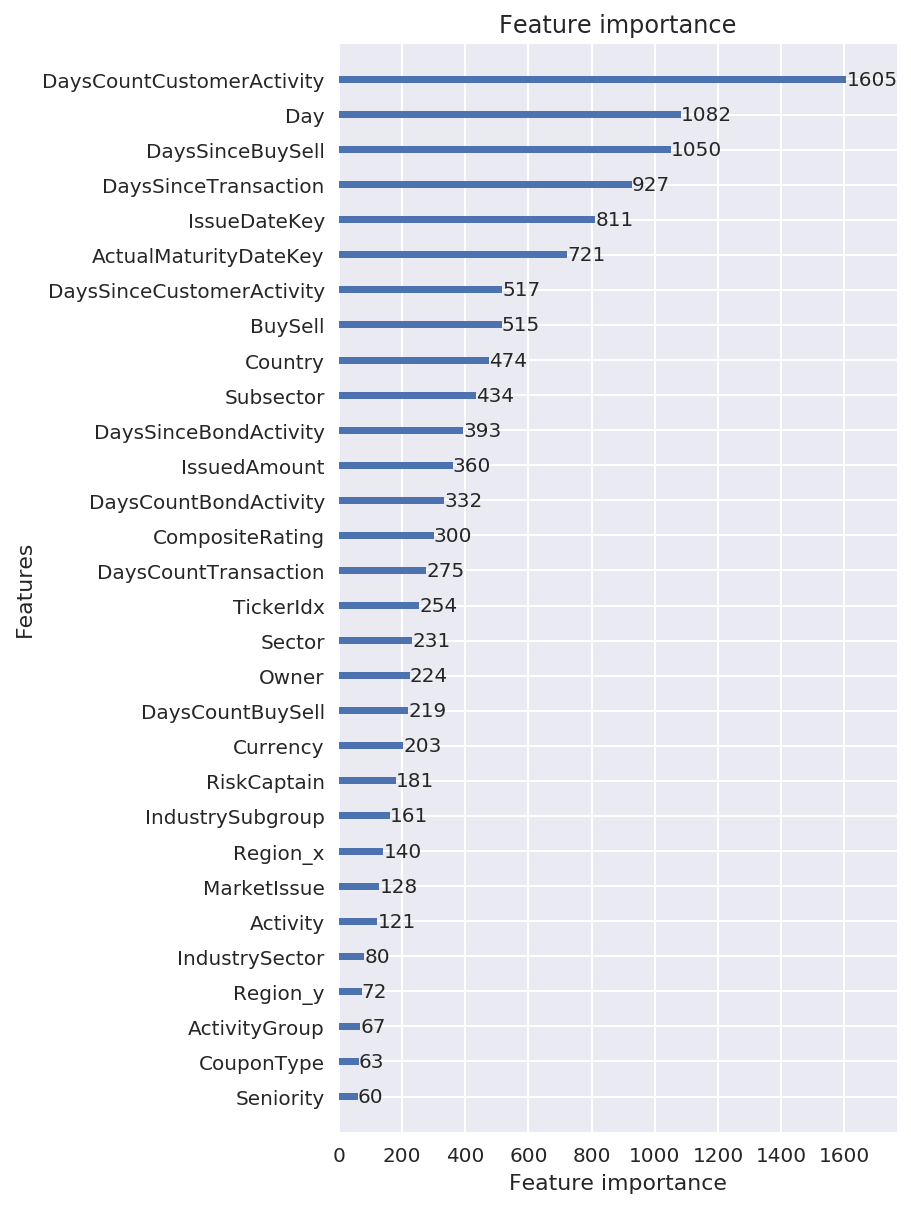

In [92]:
from lightgbm import plot_importance
plot_importance(output[-1][1], figsize=(5,10))